---
---
# NEURAL STYLE TRANSFER
---
---

# STEP 1 - Generating The Content
* E.g. given an image, can we recrate the same image

In [18]:
#from __future__ import print_function, division
#from builtins import range, input
#
#import tensorflow as tf
#
#from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
##from keras.layers.convolutional import Conv2D
#from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from tensorflow.keras.preprocessing import image
#import tensorflow.keras.backend as K #we can't use fit function, we need this to reach gradients to use gradient descent or another loss
#import matplotlib.pyplot as plt 
#import numpy as np
#from scipy.optimize import fmin_l_bfgs_b #key algorithm
#
#from __future__ import print_function, division
#from builtins import range, input
#
#
#from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
##from keras.layers.convolutional import Conv2D
#from keras.models import Model, Sequential
#from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.preprocessing import image
#import keras.backend as K #we can't use fit function, we need this to reach gradients to use gradient descent or another loss
#import matplotlib.pyplot as plt 
#import numpy as np
#from scipy.optimize import fmin_l_bfgs_b #key algorithm

In [19]:
from __future__ import print_function, division
from builtins import range, input

import tensorflow as tf

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fmin_l_bfgs_b


In [26]:
def VGG16_AvgPool(shape):
    #we want to account for features across the entire image
    #so we get rid of the maxpool which throws away information
    #NOT: we still lose some information but as much as maxpooling
    vgg = VGG16(input_shape=shape,
                weights='imagenet',
                include_top=False)
    x = vgg.input # vgg.layer[0] with another name
    for layer in vgg.layers[1:]:
        if isinstance(layer, Maxpooling2D):
            #change max pool with avg pool
            x = AveragePooling2D(pool_size=(2,2),
                                 strides=(2,2),
                                 padding='same')(x)
        else:
            #use conv relu etc. with same weights.
            x = layer(x)
    model = Model(inputs=vgg.input,outputs=x)
    return model

In [21]:
def VGG16_AvgPool_CutOff(shape, num_convs):
    # there are 13 convolutions in vgg16 total
    # we can pick any of them as the "output"
    # of our content model
    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1,13]")
        return None
    
    model = VGG16_AvgPool(shape)
    new_model = Sequential()
    n = 0
    for layer in model.layers:
        if layer.__class__ == Conv2D:
            n += 1
        new_model.add(layer)
        if n >= num_convs:
            break
    return new_model

In [22]:
# vgg expects caffe format. In coffe format, 
# RGB is converted to BGR and the channel average 
# used in ImageNet training is extracted from each channel.
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

# It performs min-max normalization by setting 
# the minimum of the image (or a gradient map) 
# to 0 and the maximum to 1.
# This is especially useful when 
# visualizing gradients or feature maps; 
# regardless of the value range, 
# the image is normalized and becomes visible on the screen.
def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

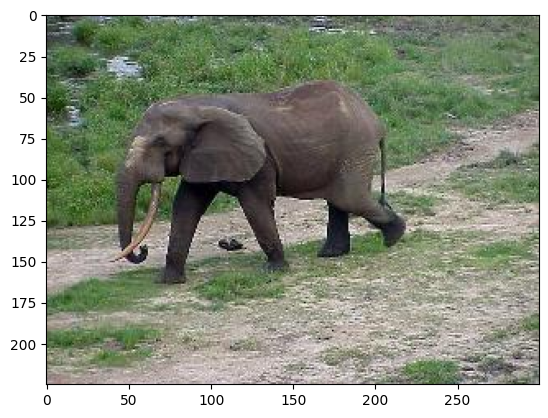

In [23]:
#load an img
path = '/kaggle/input/dataset/Data/elephant.jpg'
img = image.load_img(path)

#convert img to array and preprocess for vgg
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

#we will use this throuht the rest of the script
batch_shape = x.shape # hxwxc     #c: colour
shape = x.shape[1:]   # 1xhxwxc

#see the image
plt.imshow(img)
plt.show()

In [24]:
#make a content model

#select a cutoff to see the image that result
content_model = VGG16_AvgPool_CutOff(shape=shape, 
                                     num_convs=11)
# make the target
target = K.variable(content_model.predict(x))

#try to match the image
#define our loss in keras
loss = K.mean(K.square(target-content_model.output)) #MSE

#gradients which are needed by the optimizer
grads = K.gradients(loss, content_model.input)
get_loss_and_grads = K.function(inputs = [content_model.input],
                                outputs= [loss] + grads)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


AttributeError: The layer sequential_5 has never been called and thus has no defined output.